In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import seaborn as seabornInstance 
from scipy.stats import boxcox
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AnalyticEdge/Projet Analytics Edge/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
len(df)

6362620

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [ ]:
df.isna().sum() 

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df['isFraud'].loc[df.isFraud == 1].sum()

8213

In [ ]:
df['isFraud'].loc[df.isFlaggedFraud == 1].sum()

16

### **correlation between type and isFraud**

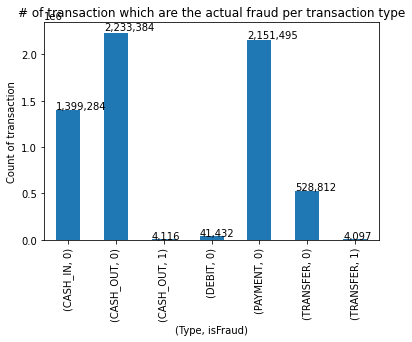

In [ ]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

we decide to drop all the lines where type=! tranfer or cashout , because if the type is different to transfer and cashout we already know that the transaction is not fraudulent

In [ ]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']


In [ ]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]))) 

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')])))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


### **is ' isFlaggedFraud ' relevant or not?**

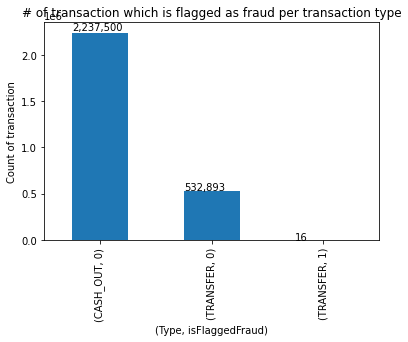

In [ ]:
ax = X.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

In [ ]:
# Investigate variable "isFlaggedFraud"
pd.crosstab(Y,X.isFlaggedFraud)

isFlaggedFraud,0,1
isFraud,,
0,2762196,0
1,8197,16


In [ ]:
df.groupby('type')['isFraud','isFlaggedFraud'].sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


in the data we have:
isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.
let's check this information

In [ ]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
XTransfer = X.loc[X.type == 'TRANSFER']
XFlagged = X.loc[X.isFlaggedFraud == 1]
XNotFlagged = X.loc[X.isFlaggedFraud == 0]
print('\nMin amount transacted when isFlaggedFraud is set= {}'\
      .format(XFlagged.amount.min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(XTransfer.loc[XTransfer.isFlaggedFraud == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


isFlaggedFraud can remain not set despite this condition being met.

### **NameOrig and NameDest are they relevant?**

In [ ]:
data_new = df.copy() # creating copy of dataset in case I need original dataset
data_new = data_new[(data_new["type"] == "CASH_OUT") | (data_new["type"] == "TRANSFER")]

In [ ]:
fraud = data_new[data_new["isFraud"] == 1]

In [ ]:
# separating transfers and cashouts for fraud accounts

fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

# checking if the recipient account of a fraudulent transfer was used as a sending account for cashing out 
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

Conclusion:
Thus in this dataset, for fraudulent transactions, the account that received funds during a transfer was not used at all for cashing out.

If that is the case, there seems to be no use for nameOrig or nameDest since there seems to be no restrictions on which accounts cashout from fraudulent transactions.

Thus, we're omitting the nameOrig and nameDest columns from analysis.

In [ ]:
# Eliminate columns shown to be irrelevant for analysis
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

### **Step and isFraud**

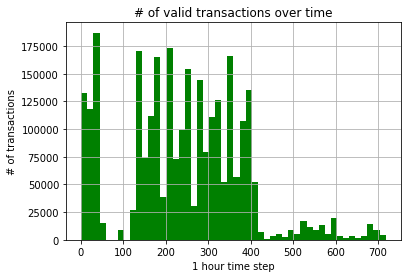

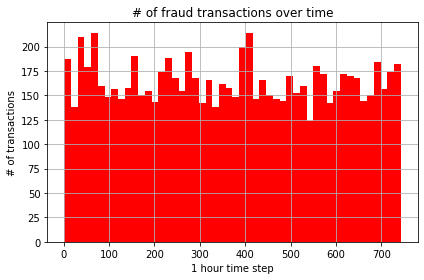

In [ ]:
# Time patterns

bins = 50

valid.hist(column="step",color="green",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

fraud.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of fraud transactions over time")

plt.tight_layout()
plt.show()

There are stark difference between the step data between valid and fraud transactions.

A large proportion of valid transactions occur between around the 0th and 60th timestep as well as the 110th and 410th time-steps.
The frequency at which fraudulent transactions occur does not seem to change much over time.

Let's see what the patterns look like over any particular, day of the week or hour of the day.

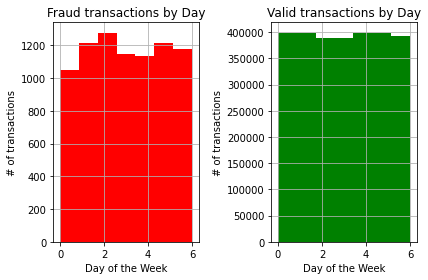

In [ ]:
# getting hours and days of the week
num_days = 7
num_hours = 24
fraud_days = fraud.step % num_days
fraud_hours = fraud.step % num_hours
valid_days = valid.step % num_days
valid_hours = valid.step % num_hours

# plotting scatterplot of the days of the week, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_days.hist(bins=num_days,color="red")
plt.title('Fraud transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.subplot(1,2,2)
valid_days.hist(bins=num_days,color="green")
plt.title('Valid transactions by Day')
plt.xlabel('Day of the Week')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

Note: With respect to days, day 0 does not necessarily mean the first day of the week, Sunday.

E.g If day 0 is Wednesday, then day 1 is Thursday, day 2 is Friday and so on...

From the graphs above, there is little evidence to suggest that fraudulent transactions occur at particular days of the week.

Much like valid transactions, fraudulent transactions seem to occur uniformally for each day of the week.

Thus I won't make a feature showing what day of the week that the transaction occured.

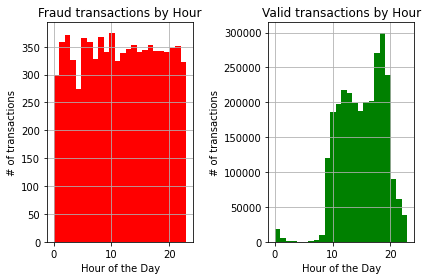

In [ ]:
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

Conclusion:
Note: With respect to days, hour 0 does not necessarily mean 1am in the morning.

E.g If hour 0 is 9am, then hour 1 is 10 am, hour 2 is 11am and so on...

From the graphs above, there is strong evidence to suggest that from hour 0 to hour 9 (inclusive) valid transactions very seldom occur. On the other hand, fraudulent transactions still occur at similar rates to any hour of the day outside of hours 0 to 9 (inclusive).

In response to this, we will create another feature HourOfDay, which is the step column with each number taken to modulo 24.

In [ ]:

X["HourOfDay"] = np.nan # initializing feature column
X.HourOfDay = X.step % 24

### **visualise balances vs isFraud**

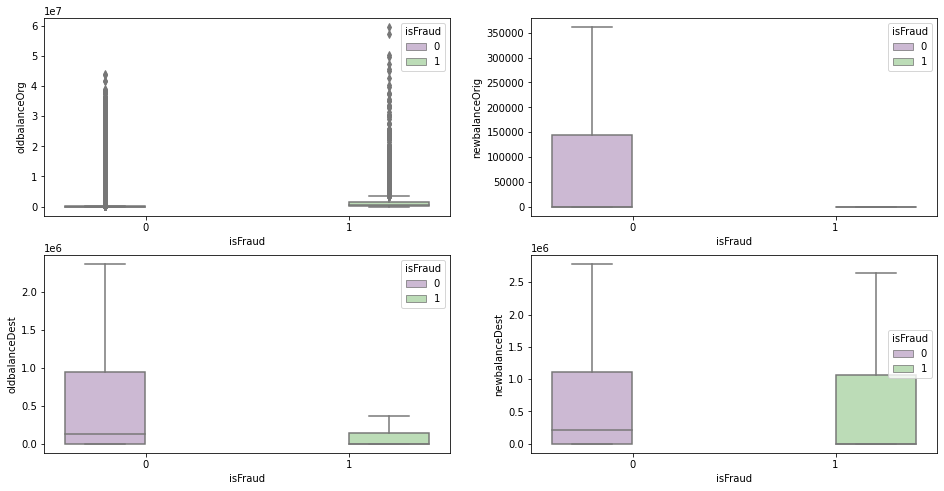

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
s = sns.boxplot(ax = axs[0][0], x="isFraud", y="oldbalanceOrg", hue="isFraud",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = axs[0][1], x="isFraud", y="newbalanceOrig", hue="isFraud",data=df, palette="PRGn",showfliers=False)
s = sns.boxplot(ax = axs[1][0], x="isFraud", y="oldbalanceDest", hue="isFraud",data=df, palette="PRGn",showfliers=False)
s = sns.boxplot(ax = axs[1][1], x="isFraud", y="newbalanceDest", hue="isFraud",data=df, palette="PRGn",showfliers=False)
plt.show()

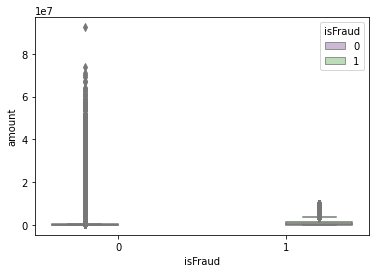

In [ ]:
s = sns.boxplot(x="isFraud", y="amount", hue="isFraud",data=df, palette="PRGn",showfliers=True)
plt.show()

### correlation between amount and isFraud

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


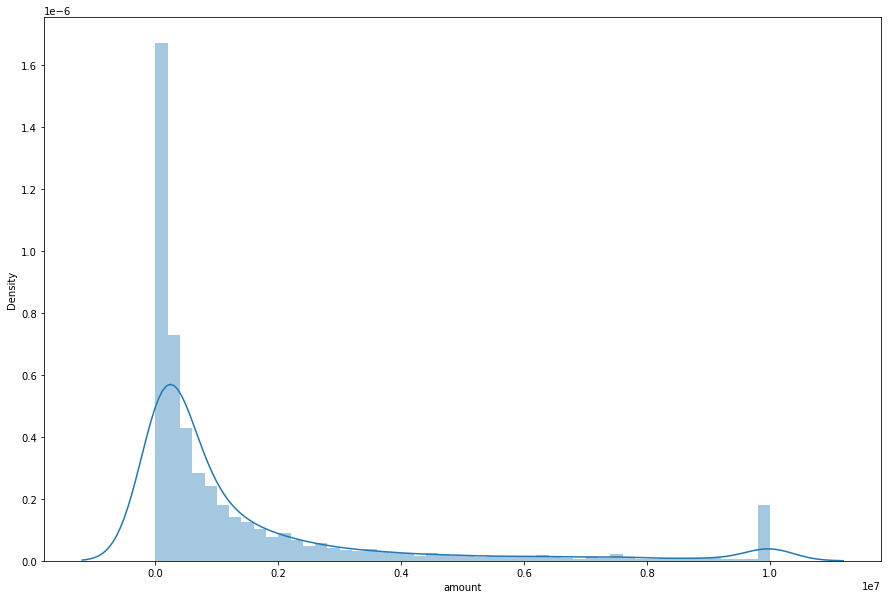

In [ ]:
#distplot
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(fraud['amount'])

In [ ]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,HourOfDay
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,1
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,1
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,1


### others remarks


In [ ]:
print("percentage for fraudulent transactions that has zero balances in the destination account both before and after a non-zero amount : {}".
      format((fraud.loc[(fraud.oldbalanceDest == 0) & (fraud.newbalanceDest == 0) & (fraud.amount != 0)].shape[0])/(fraud.shape[0])))
print("percentage for valid transactions that has zero balances in the destination account both before and after a non-zero amount : {}".
      format((valid.loc[(valid.oldbalanceDest == 0) & (valid.newbalanceDest == 0) & (valid.amount != 0)].shape[0])/(valid.shape[0])))

percentage for fraudulent transactions that has zero balances in the destination account both before and after a non-zero amount : 0.4955558261293072
percentage for valid transactions that has zero balances in the destination account both before and after a non-zero amount : 0.0006176245277308345


The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (49.55%) compared to genuine transactions (0.06%).

In [ ]:
print("percentage of fraudulent transactions with zero balances in the destination account both before and after a non-zero amount : {}".
      format((fraud.loc[(fraud.oldbalanceDest == 0) & (fraud.newbalanceDest == 0) & (fraud.amount != 0)].shape[0])/(X.shape[0])))
print("percentage of valid transactions with zero balances in the destination account both before and after a non-zero amount : {}".
      format((valid.loc[(valid.oldbalanceDest == 0) & (valid.newbalanceDest == 0) & (valid.amount != 0)].shape[0])/(X.shape[0])))

percentage of fraudulent transactions with zero balances in the destination account both before and after a non-zero amount : 0.0014690971621879657
percentage of valid transactions with zero balances in the destination account both before and after a non-zero amount : 0.0006157935525043414


Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [ ]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), ['oldbalanceDest', 'newbalanceDest']] = - 1

In [ ]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,HourOfDay
2,1,TRANSFER,181.00,181.0,0.0,-1.0,-1.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,1
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,1
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,1


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


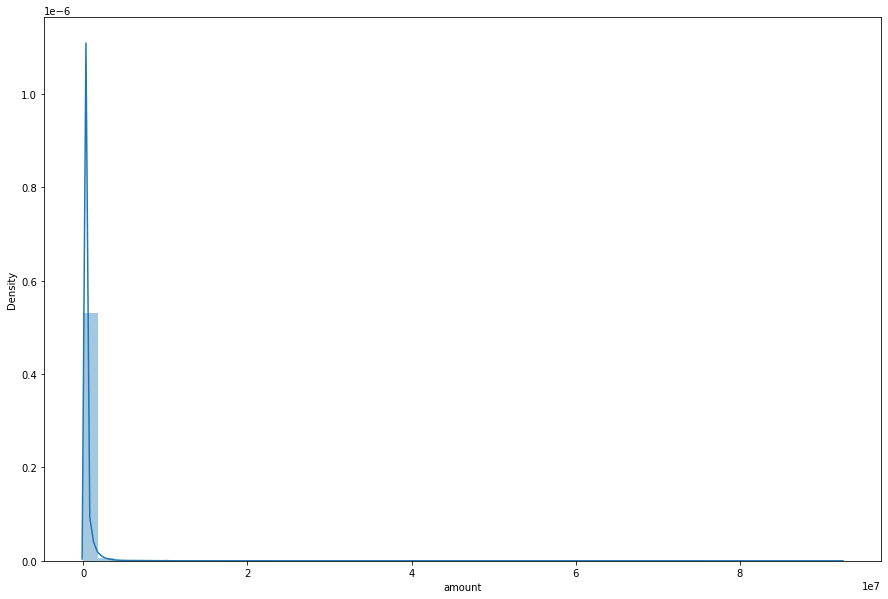

In [ ]:
#distplot
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(valid['amount'])

### feature engineering

we introduce two new columns which will improve ML model

In [ ]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

In [ ]:
print('Percentage of transactions with non-zero \'errorBalanceOrig\'')
pd.DataFrame(X.groupby('type').apply(lambda X:len(X.loc[X.errorBalanceOrig != 0]) / len(X)))

Percentage of transactions with non-zero 'errorBalanceOrig'


,0
type,
CASH_OUT,0.898052
TRANSFER,0.958963


In [ ]:
print('Percentage of transactions with non-zero \'errorBalanceDest\'')
pd.DataFrame(X.groupby('type').apply(lambda X:len(X.loc[X.errorBalanceDest != 0]) / len(X)))

Percentage of transactions with non-zero 'errorBalanceDest'


,0
type,
CASH_OUT,0.417347
TRANSFER,0.436039


In [ ]:
# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

In [ ]:
# the feature 'HourOfDay' we added previously replaces 'step', ie we considered that we have extracted the relevant information from step
# del X['step']

In [ ]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,HourOfDay,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,1,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,1,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,1,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,1,300850.89,-2401220.0


# ML Classification Models


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
def predictions_generator(model,hyper_params_range):
  grid = GridSearchCV(estimator=model,param_grid=hyper_params_range, cv=4,n_jobs=-1)
  grid.fit(X_train, y_train)
  print({'best_hyerparameters':grid.best_params_,
          'best_CV_score':grid.best_score_})
  opt_model = grid.best_estimator_.fit(X_train,y_train)
  return opt_model.predict(X_test)

In [ ]:
def model_results(model):
  print('Confusion matrix \n', pd.DataFrame(confusion_matrix(y_test, model.predict(X_test)), columns=['Predicted is not fraud', "Predicted isfraud"], index=['Actual is not fraud', 'Actual isfraud']))
  print('accuracy : ', accuracy_score(y_test,model.predict(X_test)))
  plot_roc_curve(model, X_test, y_test) 
  plt.show()


## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

Log_reg = LogisticRegression(random_state=0)
Log_reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828326                301
Actual isfraud                         1178               1318
accuracy :  0.998220480001155


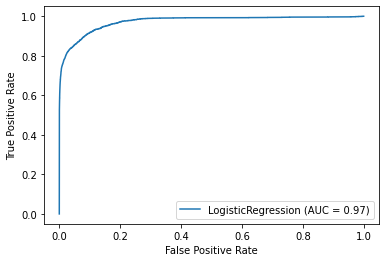

In [ ]:
model_results(Log_reg)

It has less negative impact to predict 'fraudulent' a non fraudulent transaction than predicting 'non fraudulent' a fraudulent transaction because in the first case, the bank administrator can block the transaction and check the informations before relaunching it if all is fine, but in the second case, a fraud is committed and nobody noted that. Therefore we have to minimise the rate of false-negative.

## XGBoost classifier


In [ ]:
pip install xgboost

In [ ]:
# XGB with weigths
from xgboost import XGBClassifier
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # giving class weight
XGB = XGBClassifier(scale_pos_weight= weights, n_jobs = -1, random_state=42)
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=336.3199805186899,
              seed=None, silent=None, subsample=1, verbosity=1)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828407                220
Actual isfraud                            9               2487
accuracy :  0.9997244691820585


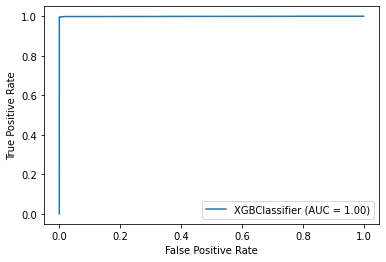

In [ ]:
model_results(XGB)

In [ ]:
# XGB without weigths
XGB_weightless = XGBClassifier(random_state=42)
XGB_weightless.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828627                  0
Actual isfraud                           11               2485
accuracy :  0.9999867648952081


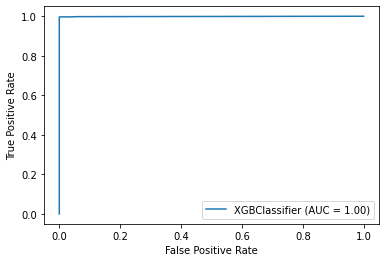

In [ ]:
model_results(XGB_weightless)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

r_clf=RandomForestClassifier()
r_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828626                  1
Actual isfraud                           13               2483
accuracy :  0.9999831553211739


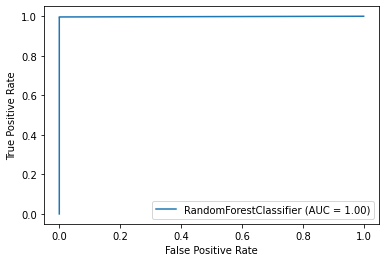

In [ ]:
model_results(r_clf)


The above models all score well in terms of overall accuracy, but the XGB_weightless and RandomForest models particularly stand out from the rest since they negate (or almost) false negatives while considerably reducing false positives.

## skewness and curtosis of numerical features

We have noted that our data is highly skewed. This can have an impact on the predictions. We will perform some data transformation to reduce to skewness of our data.

### BoxCox transformation

In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew


In [ ]:
# liste des features à transformer avec boxcox
to_boxcox_features = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

In [ ]:
def skew_kurtosis(feature):
  print(feature ,' : ' ,skew(X[feature]) , kurtosis(X[feature]))

In [ ]:
for i in to_boxcox_features:
  skew_kurtosis(i)

amount  :  21.934931099074923 868.5558639605916
oldbalanceOrg  :  70.01171346312138 9402.871458082058
newbalanceOrig  :  127.31948754910496 27926.00256696951
oldbalanceDest  :  17.160171845520445 668.8118589282553
newbalanceDest  :  16.433838497460286 585.0259199903767


In [ ]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,HourOfDay,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,1,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,1,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,1,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,1,300850.89,-2401220.0


Now we will perform data transformation to reduce skewness using boxcox

In [ ]:
X_boxcox = X.copy()

In [ ]:
def to_boxcox(feature):
  X_boxcox[feature+'_boxcox'] = preprocessing.scale(boxcox(X_boxcox[feature]+2)[0])

  figure = plt.figure(figsize=(16, 5))
  figure.add_subplot(131) 
  plt.hist(X_boxcox[feature] ,facecolor='blue',alpha=0.75) 
  plt.xlabel(feature) 
  plt.title("initial distribution of "+feature) 
  plt.text(10,100000,"Skewness: {0:.2f}".format(skew(X_boxcox[feature])))

  figure.add_subplot(132)
  plt.hist(np.sqrt(X_boxcox[feature]), facecolor = 'red', alpha=0.5)
  plt.xlabel("Square root of "+feature)
  plt.title("Using SQRT on "+feature)
  plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(X_boxcox[feature]))))

  figure.add_subplot(133)
  plt.hist(X_boxcox[feature+'_boxcox'], facecolor = 'red', alpha=0.5)
  plt.xlabel("Box cox of "+feature)
  plt.title("Using Box cox on "+feature)
  plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(X_boxcox[feature+'_boxcox'])))

  plt.show()
  del X_boxcox[feature]

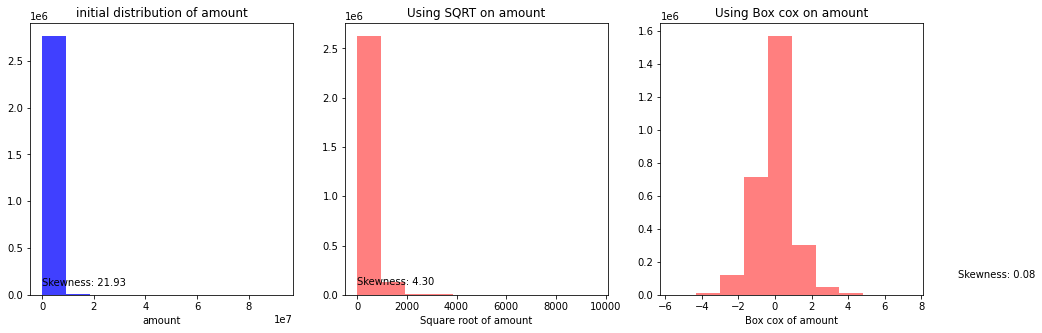

In [ ]:
# amount to boxcox
to_boxcox('amount')

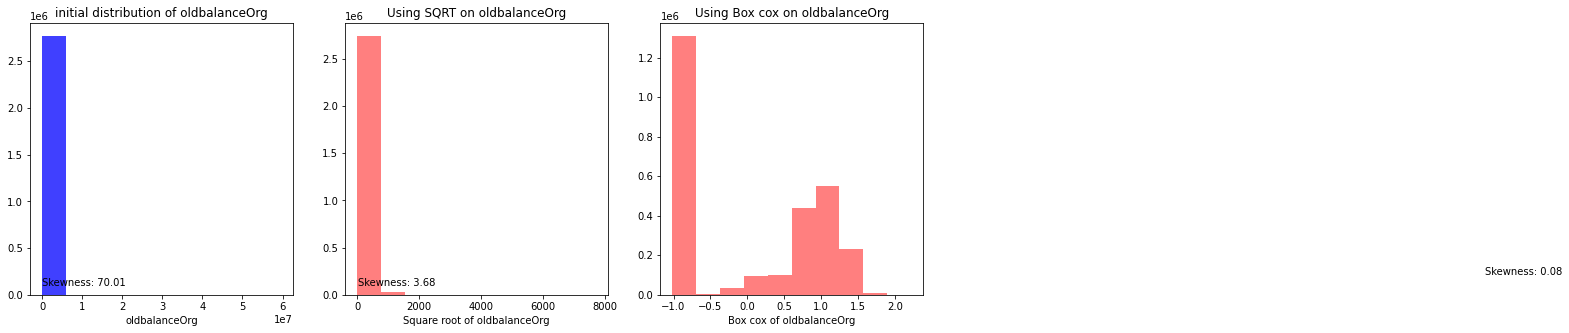

In [ ]:
# 'oldbalanceOrg' to boxcox
to_boxcox('oldbalanceOrg')

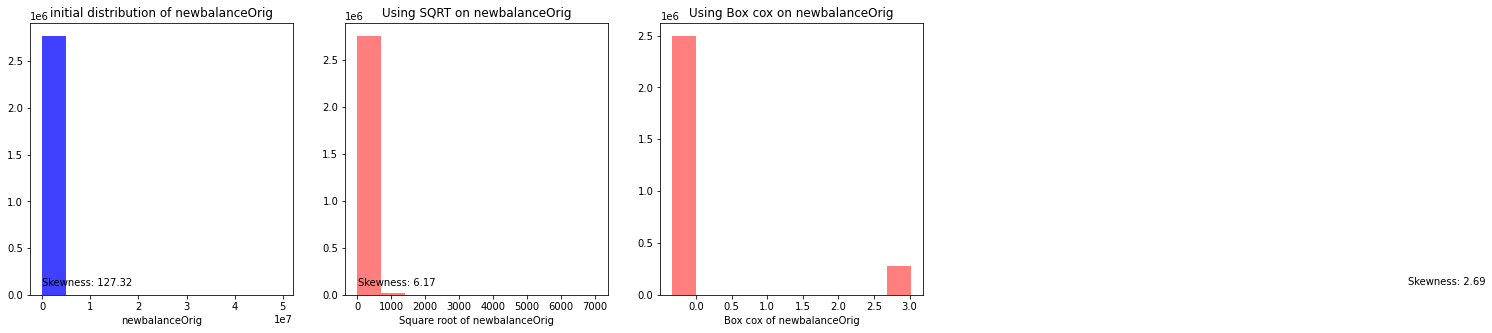

In [ ]:
# newbalanceOrig to boxcox
to_boxcox('newbalanceOrig')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


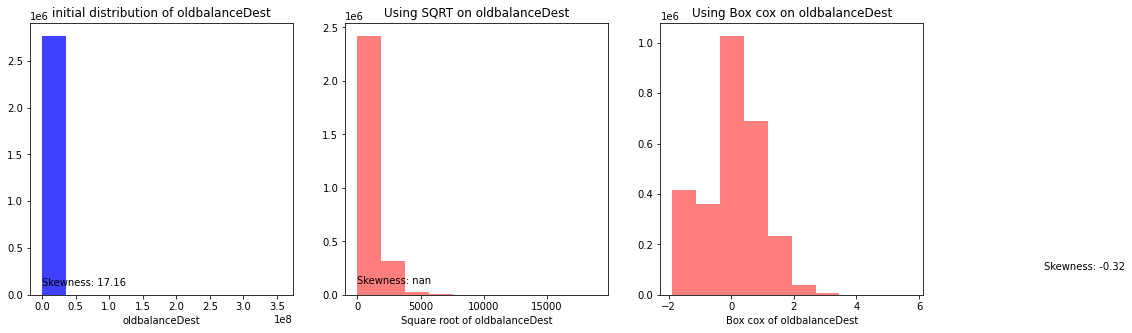

In [ ]:
# oldbalanceDest to boxcox
to_boxcox('oldbalanceDest')

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


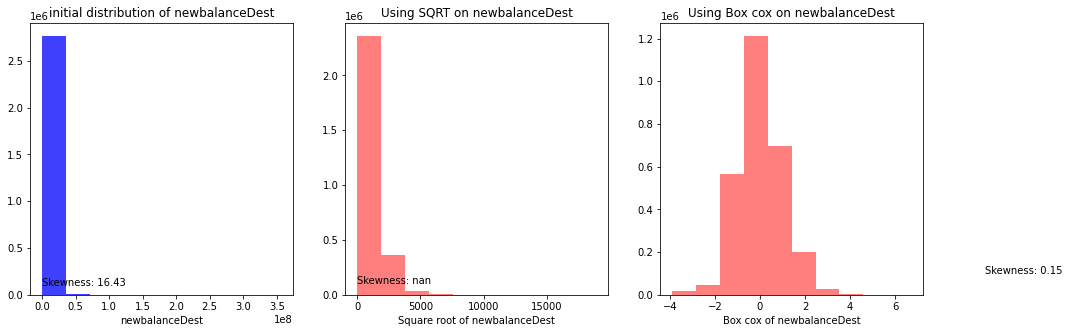

In [ ]:
# newbalanceDest to boxcox 
to_boxcox('newbalanceDest')

In [ ]:
X_boxcox.head()

,step,type,HourOfDay,errorBalanceOrig,errorBalanceDest,amount_boxcox,oldbalanceOrg_boxcox,newbalanceOrig_boxcox,oldbalanceDest_boxcox,newbalanceDest_boxcox
2,1,0,1,0.00,181.0,-4.096001,-0.015336,-0.331126,-1.883192,-3.894139
3,1,1,1,0.00,21363.0,-4.096001,-0.015336,-0.331126,-0.927804,-3.834587
15,1,1,1,213808.94,182703.5,0.287972,0.853104,-0.331126,-1.202908,-1.594997
19,1,0,1,214605.30,237735.3,0.234347,0.260917,-0.331126,-0.915090,-3.834587
24,1,0,1,300850.89,-2401220.0,0.558184,0.788825,-0.331126,-1.167311,0.805964


In [ ]:
X_boxcox['errorBalanceOrig'] = X_boxcox.newbalanceOrig_boxcox + X_boxcox.amount_boxcox - X_boxcox.oldbalanceOrg_boxcox
X_boxcox['errorBalanceDest'] = X_boxcox.oldbalanceDest_boxcox + X_boxcox.amount_boxcox - X_boxcox.newbalanceDest_boxcox

**ML Models applied to BoxCox-ed data**

In [ ]:
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_boxcox, Y, test_size=0.3, random_state=42)

In [ ]:
def model_results_bc(model):
  print('Confusion matrix \n', pd.DataFrame(confusion_matrix(y_test_bc, model.predict(X_test_bc)), columns=['Predicted is not fraud', "Predicted isfraud"], index=['Actual is not fraud', 'Actual isfraud']))
  print('accuracy : ', accuracy_score(y_test_bc,model.predict(X_test_bc)))
  plot_roc_curve(model, X_test_bc, y_test_bc) 
  plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828585                 42
Actual isfraud                         1415               1081
accuracy :  0.998246950210739


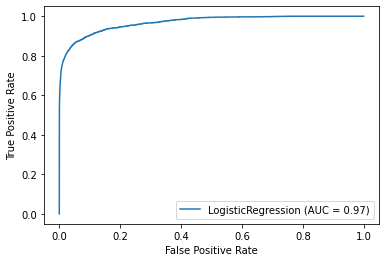

In [ ]:
# logistic regression

Log_reg = LogisticRegression(random_state=0)
Log_reg.fit(X_train_bc,y_train_bc)

model_results_bc(Log_reg)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  814134              14493
Actual isfraud                           13               2483
accuracy :  0.9825465063534519


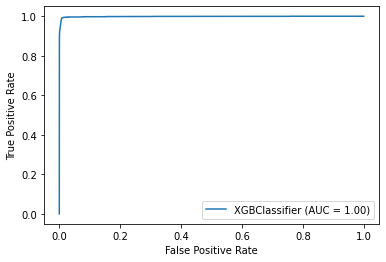

In [ ]:
# XGB with weigths

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # giving class weight
XGB = XGBClassifier(scale_pos_weight= weights, n_jobs = -1, random_state=42)
XGB.fit(X_train_bc, y_train_bc)

model_results_bc(XGB)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828608                 19
Actual isfraud                          514               1982
accuracy :  0.9993586990132628


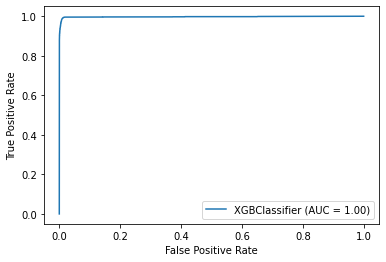

In [ ]:
# XGB without weigths
XGB_weightless = XGBClassifier(random_state=42)
XGB_weightless.fit(X_train_bc, y_train_bc)

model_results_bc(XGB_weightless)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828592                 35
Actual isfraud                          409               2087
accuracy :  0.9994657830429431


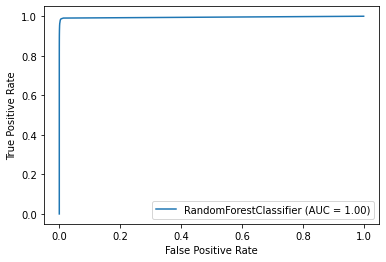

In [ ]:
# random forest classifier
r_clf=RandomForestClassifier()
r_clf.fit(X_train_bc,y_train_bc)

model_results_bc(r_clf)

Despite the fact that BoxCox considerably reduces the skewness of each column, predictions are not improved compared to the normal data case. This is probably due to the fact boxcox is applied to each feature independently to others. Therefore, the scale between features are no more respected (the definition of balances error are skewed for example). 

Now we will try to apply the same (log) transformation to all the features to preserve that relative scale while reducing the skewness of data.

### Log-transformation

In [ ]:
from scipy.stats import kurtosis
from scipy.stats import skew


In [ ]:
# liste des features à transformer avec boxcox
to_log_features = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

Now we will perform data transformation to reduce skewness using Log transformation

In [ ]:
import math
def log_trans(x):
  if x==-1:
    return -1
  else:
    return math.log1p(x)

In [ ]:
X_log = X.copy()

In [ ]:
for f in to_log_features:
  X_log[f] = X_log[f].apply(log_trans)

In [ ]:
X_log.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,HourOfDay,errorBalanceOrig,errorBalanceDest
2,1,0,5.204007,5.204007,0.0,-1.000000,-1.000000,1,0.00,181.0
3,1,1,5.204007,5.204007,0.0,9.960954,0.000000,1,0.00,21363.0
15,1,1,12.342066,9.637306,0.0,8.533854,10.849617,1,213808.94,182703.5
19,1,0,12.279840,6.559615,0.0,10.017976,0.000000,1,214605.30,237735.3
24,1,0,12.649754,9.290629,0.0,8.743213,14.815839,1,300850.89,-2401220.0


In [ ]:
def log_skew(feature):
  print(feature ,' : ' ,skew(X[feature]) , skew(X_boxcox[feature+'_boxcox']) , skew(X_log[feature]))

In [ ]:
for i in to_log_features:
  log_skew(i)

amount  :  21.934931099074923 0.0838543253245437 -0.6988895540430183
oldbalanceOrg  :  70.01171346312138 0.08044554306854679 0.0941757693717401
newbalanceOrig  :  127.31948754910496 2.6889231666991753 2.7872861453093036
oldbalanceDest  :  17.160171845520445 -0.3247421248375664 -1.7045503345364068
newbalanceDest  :  16.433838497460286 0.14931768952968996 -2.963342047460222


we can noted that the log-transformation is a little less efficient than the boxcox transformation in terms of reducing the skewness.

In [ ]:
# feature engineering

X_log['errorBalanceOrig'] = X_log.newbalanceOrig + X_log.amount - X_log.oldbalanceOrg
X_log['errorBalanceDest'] = X_log.oldbalanceDest + X_log.amount - X_log.newbalanceDest

**ML Models applied to log-ed data**

In [ ]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, Y, test_size=0.3, random_state=42)

In [ ]:
def model_results_log(model):
  print('Confusion matrix \n', pd.DataFrame(confusion_matrix(y_test_log, model.predict(X_test_log)), columns=['Predicted is not fraud', "Predicted isfraud"], index=['Actual is not fraud', 'Actual isfraud']))
  print('accuracy : ', accuracy_score(y_test_log,model.predict(X_test_log)))
  plot_roc_curve(model, X_test_log, y_test_log) 
  plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828464                163
Actual isfraud                         1136               1360
accuracy :  0.9984370544432052


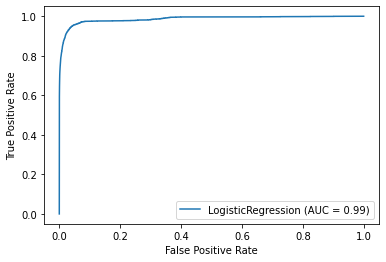

In [ ]:
# logistic regression

Log_reg = LogisticRegression(random_state=0)
Log_reg.fit(X_train_log,y_train_log)

model_results_log(Log_reg)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828404                223
Actual isfraud                            9               2487
accuracy :  0.9997208596080244


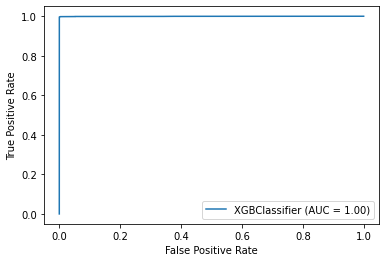

In [ ]:
# XGB with weigths

weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) # giving class weight
XGB = XGBClassifier(scale_pos_weight= weights, n_jobs = -1, random_state=42)
XGB.fit(X_train_log, y_train_log)

model_results_log(XGB)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828627                  0
Actual isfraud                           13               2483
accuracy :  0.9999843585125187


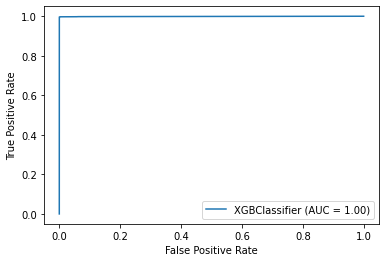

In [ ]:
# XGB without weigths
XGB_weightless = XGBClassifier(random_state=42)
XGB_weightless.fit(X_train_log, y_train_log)

model_results_log(XGB_weightless)

Confusion matrix 
                      Predicted is not fraud  Predicted isfraud
Actual is not fraud                  828627                  0
Actual isfraud                           11               2485
accuracy :  0.9999867648952081


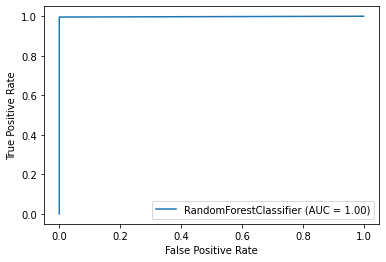

In [ ]:
# random forest classifier
r_clf=RandomForestClassifier()
r_clf.fit(X_train_log,y_train_log)

model_results_log(r_clf)

# Conclusions

The models we have trained with the aim to predict if a bank transaction is a fraud or not are very precise, but not perfect. The choice to work with one and not the others in real life cases depends on the cost of a false negative vs false positive mistake.

In this line of ideas, it can be relevant to make a comparative study between the cost of increasing our false negative rate by 2, and the cost of increasing our false positive rate by 223 (Randomforest VS XGBoost with weights applied on log-transformed data).
